# Study of the parameters

The objective of this study is to determine the influence of the different parameters on the power distribution. We will now focus on the dynamic model which is described in DMPC.py.

One of the principal issue here is to get an overview of the compfort parameter in order to use it to cheat (in the CMPC at first).

Please note that for the simplicity of this study we focused on the centralized MPC. All those results can be extended to the DMPC.


-- Sylvain Chatel, July 2016 --

In [1]:
from __future__ import division, print_function
import DMPC_Draft as DO
import fctIPYNB as FCT
from cvxopt import matrix, solvers
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from tempfile import TemporaryFile
%matplotlib inline

/Users/sylvainchatel/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Influence of the comfort parameter for two users

### Definition of the problem

In [2]:
# number of users
m = 2
# vector of users
i = np.arange(m)
# Time step
dt = 0.1  # h
# Simulation Horizon
N_sim = int(24/dt)
# Prediction Horizon
N = int(5/dt)
# time vector
t = np.arange(N + N_sim) * dt
t_sim = np.arange(N_sim) * dt
# max energy in kW
Umax = 3
# max admissible energy
u_m = np.array([2, 2], dtype=float)
# thermal parameters
        ## Exterior Temperature on the whole horizon
Text_sim = np.ones(m*(N_sim + N))*0
        ## Exterior Temperature on the prediction horizon initially
Text = Text_sim[0:m*N]
        ## Temperature when present
Tpres = 22
        ## Temperature when absent
Tabs = 18
        ## Initial temperature in all users
T_init = np.array([10, 10], dtype=float)
        ## Thermal Resistance
Rth = np.array([50, 50], dtype=float)
        ## Thermal Capacity
Cth = 2*np.array([0.056, 0.056], dtype=float)
        ## Reference temperature through the whole horizon
T_mod = np.hstack(
    (DO.temp_id(N_sim + N, dt, Tabs, Tpres), DO.temp_id(N_sim + N, dt, Tabs, Tpres)))  ## ATTENTION : defined user after user
        ## Reference temperature through the simulation horizon
T_id_pred = np.hstack(
    (DO.temp_id(N_sim, dt, Tabs, Tpres), DO.temp_id(N_sim, dt, Tabs, Tpres)))  ## ATTENTION : defined user after user
# comfort factor
alpha = np.array([10, 10], dtype=float)
alpha_2 = np.array([10, 100], dtype=float)

## Verifications
assert len(u_m) == m, "illegal number of users. Expecting %s. and received %s." % (m, len(u_m))
assert len(T_init) == m, "illegal number of T_init. Expecting %s. and received %s." % (m, len(T_init))
assert len(Rth) == m, "illegal number of Rth. Expecting %s. and received %s." % (m, len(Rth))
assert len(Cth) == m, "illegal number of Cth. Expecting %s. and received %s." % (m, len(Cth))
assert len(alpha) == m, "illegal number of alpha. Expecting %s. and received %s." % (m, len(alpha))

# Definition of the dictionary
pb_1 = dict(m=m, dt=dt, Umax=Umax, u_m=u_m, Text=Text, Text_sim=Text_sim, T_mod=T_mod, T_init=T_init, Rth=Rth, Cth=Cth,
          T_id_pred=T_id_pred, alpha=alpha, N=N, N_sim=N_sim)

pb_2 = dict(m=m, dt=dt, Umax=Umax, u_m=u_m, Text=Text, Text_sim=Text_sim, T_mod=T_mod, T_init=T_init, Rth=Rth, Cth=Cth,
          T_id_pred=T_id_pred, alpha=alpha_2, N=N, N_sim=N_sim)

In [3]:
T_1, U_1, cost_1, J_u_1 = DO.optim_central_CL(pb_1)
T_2, U_2, cost_2, J_u_2 = DO.optim_central_CL(pb_2)

T_1 = T_1.reshape((N_sim, 2))
T_2 = T_2.reshape((N_sim, 2))
U_1 = U_1.reshape((N_sim, 2))
U_2 = U_2.reshape((N_sim, 2))

(0, 10)

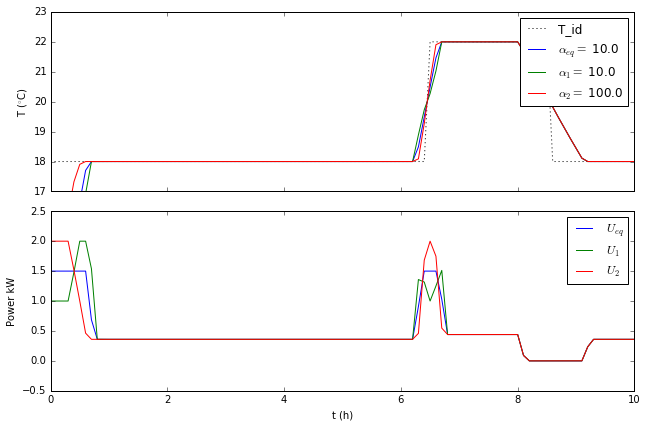

In [4]:
FCT.plot_T_tot(pb_1, pb_2, T_1, U_1, T_2, U_2)
plt.xlim(0,10)

(6, 7)

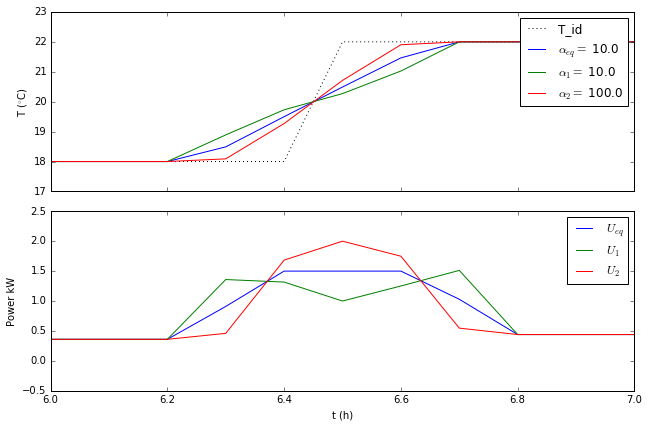

In [5]:
FCT.plot_T_tot(pb_1, pb_2, T_1, U_1, T_2, U_2)
plt.xlim(6,7)

In [6]:
pb_2['alpha'] = np.array([10, 1000], dtype=float)

(0, 10)

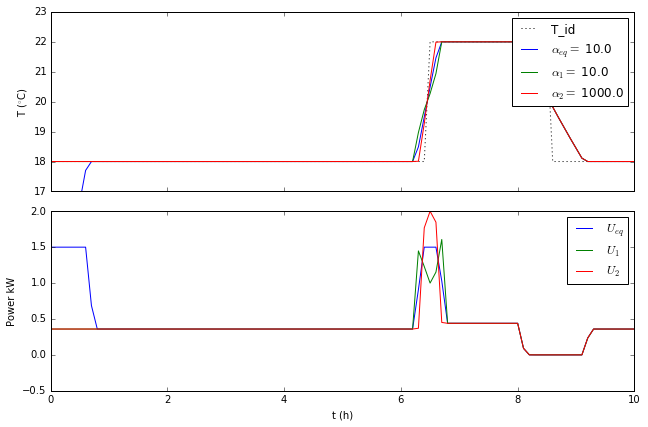

In [7]:
T_2, U_2, cost_2, J_u_2 = DO.optim_central_CL(pb_2)
T_2 = T_2.reshape((N_sim, 2))
U_2 = U_2.reshape((N_sim, 2))
FCT.plot_T_tot(pb_1, pb_2, T_1, U_1, T_2, U_2)
plt.xlim(0,10)

On the figure above, we can see in blue the balanced situation (both users with the same comfort factor). The other two colored plot are when the comfort is not even. The red user has a comfort factor superior to the green user. We can observe that the red user get the ideal temperature much faster than the green user who is clearly disavantaged.

The following function *DO.get_data* prints a table with different information : the first row represents the mean cosumed energy for each user, the second row shows the average quadratic mean of the temperature. Each column represent a different user. 
Finally, the number below is the average value of the cost function.

In [8]:
DO.get_data(pb_1, J_u_1, U_1, T_1)

--------  --------
0.415310  0.415310
0.664521  0.664521
--------  --------
139.625848682


In [9]:
DO.get_data(pb_2, J_u_2, U_2, T_2)

--------  --------
0.380698  0.380725
0.189607  0.149739
--------  --------
6539.50369923


We can notice that in both cases the consumed energy is notably similar.

## Influence of the reference temperature

The objective of this part is to determine the influence of the reference temperature. We consider a system with two rooms and each room has a different reference profile.

In [10]:
# number of users
m = 2
# vector of users
i = np.arange(m)
# Time step
dt = 0.1  # h
# Simulation Horizon
N_sim = int(24/dt)
# Prediction Horizon
N = int(5/dt)
# time vector
t = np.arange(N + N_sim) * dt
t_sim = np.arange(N_sim) * dt
# max energy in kW
Umax = 3
# max admissible energy
u_m = np.array([2, 2], dtype=float)
# thermal parameters
        ## Exterior Temperature on the whole horizon
Text_sim = np.ones(m*(N_sim + N))*0
        ## Exterior Temperature on the prediction horizon initially
Text = Text_sim[0:m*N]
        ## Temperature when present
Tpres = 22
        ## Temperature when absent
Tabs = 18
        ## Initial temperature in all users
T_init = np.array([10, 10], dtype=float)
        ## Thermal Resistance
Rth = np.array([50, 50], dtype=float)
        ## Thermal Capacity
Cth = 2*np.array([0.056, 0.056], dtype=float)
        ## Reference temperature through the whole horizon
T_mod = np.hstack(
    (DO.temp_id(N_sim + N, dt, Tabs+1, Tpres+2), DO.temp_id(N_sim + N, dt, Tabs, Tpres)))  ## ATTENTION : defined user after user
        ## Reference temperature through the simulation horizon
T_id_pred = np.hstack(
    (DO.temp_id(N_sim, dt, Tabs+1, Tpres+2), DO.temp_id(N_sim, dt, Tabs, Tpres)))  ## ATTENTION : defined user after user
# comfort factor
alpha = np.array([10, 10], dtype=float)

## Verifications
assert len(u_m) == m, "illegal number of users. Expecting %s. and received %s." % (m, len(u_m))
assert len(T_init) == m, "illegal number of T_init. Expecting %s. and received %s." % (m, len(T_init))
assert len(Rth) == m, "illegal number of Rth. Expecting %s. and received %s." % (m, len(Rth))
assert len(Cth) == m, "illegal number of Cth. Expecting %s. and received %s." % (m, len(Cth))
assert len(alpha) == m, "illegal number of alpha. Expecting %s. and received %s." % (m, len(alpha))

# Definition of the dictionary
pb = dict(m=m, dt=dt, Umax=Umax, u_m=u_m, Text=Text, Text_sim=Text_sim, T_mod=T_mod, T_init=T_init, Rth=Rth, Cth=Cth,
          T_id_pred=T_id_pred, alpha=alpha, N=N, N_sim=N_sim)

In [11]:
T_0, U_0, cost_0, J_u_0 = DO.optim_central_CL(pb)
T_id_pred =  T_id_pred.reshape((N_sim, 2))
T_0 = T_0.reshape((N_sim, 2))
U_0 = U_0.reshape((N_sim, 2))

DO.get_data(pb, J_u_0, U_0, T_0)

--------  --------
0.444804  0.415020
0.900004  0.789174
--------  --------
206.528807337


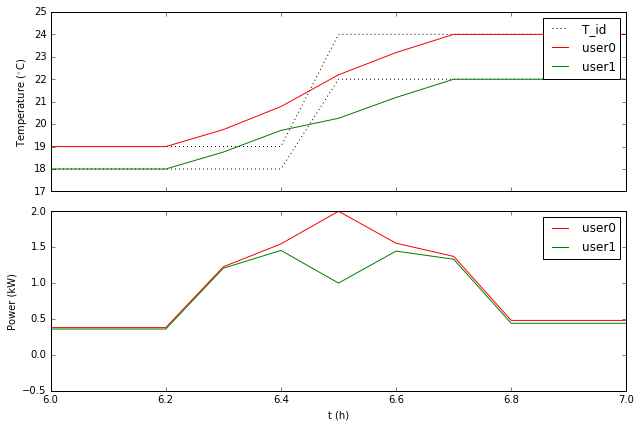

(<matplotlib.figure.Figure at 0x10cea4410>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x10cf0ac90>,
  <matplotlib.axes._subplots.AxesSubplot at 0x110312e50>))

In [12]:
FCT.plot_2usr(pb, T_0, U_0, 0, 'user0', T_0, U_0, 1, 'user1')

We can notice that the optimisation problem enable each user to get at the same time the ideal temperature.  

# Conclusion

Thanks to this study, we understand the importance in a DMPC situation of all the different parameters. Both the comfort factor and the reference temperature are crucial to solve properly the optimization problem. 

One who would want to cheat and mislead the DMPC could do so by modifying ones comfort factor and the broadcasted temperature of reference (*for more details on that aspect, the reader can refer to Static_cheating_DMPC where the influence of the broadcasted temperature and the real desired temperature is analysed*).